In [8]:
import sys, math
from collections import namedtuple
import numpy as np
import pandas as pd
import pygame
import random
import lzma
import os

DATA_DIRECTORY = "data/2023_2/"
INPUT_FILE = 'KA050_processed_10cm_5h_20230614_angles.pkl.xz'

def load_data(source_dir, input_file, scale = None, arena_dim = None):
    data = None
    with lzma.open(os.path.join(source_dir, input_file)) as file:
        data = pd.read_pickle(file)
    return data.iloc[::int(scale)] if scale else data


def process_data(data, arena_dim):
    data_len = len(data)
    arena_bb = find_bounding_box(data)
    origin_arena = calculate_circle(*arena_bb)

    translation, scale = circle_transformation(origin_arena, arena_dim)

    apply_transform_scale(data, translation, scale)

    return data

data = load_data(DATA_DIRECTORY, INPUT_FILE)

In [9]:
# Define the framerate
FRAME_RATE = 60  # frames per second

# Load the dataframe from the pickle file
df = data

# Initialize lists to store all distances, speeds, and turning rates
all_distances = []          # Distance per frame
all_speeds = []             # Speed in units per second
all_turning_rates = []      # Turning rates per frame
all_turning_rates_sec = []  # Turning rates in radians per second

for ant in df.columns.levels[0]:  # Iterate over each ant (0 to 56)
    ant_data = df[ant].dropna()    # Remove rows where this ant has no data

    if len(ant_data) < 2:
        continue  # Need at least two points to compute differences

    # Calculate differences in positions
    delta_x = ant_data['x'].diff()
    delta_y = ant_data['y'].diff()
    distance = np.sqrt(delta_x**2 + delta_y**2)

    # Append non-zero distances
    non_zero_distances = distance[distance > 0].tolist()
    all_distances.extend(non_zero_distances)

    # Calculate speeds (units per second)
    speed = distance * FRAME_RATE  # units/frame * frames/second = units/second
    non_zero_speeds = speed[speed > 0].tolist()
    all_speeds.extend(non_zero_speeds)

    # Calculate differences in smoothed_theta
    delta_theta = ant_data['smoothed_theta'].diff().abs()

    # Handle angle wrapping
    delta_theta = delta_theta.apply(lambda x: min(x, 2*np.pi - x))

    # Append turning rates per frame
    turning_rates = delta_theta.dropna().tolist()
    all_turning_rates.extend(turning_rates)

    # Calculate turning rates in radians per second
    turning_rates_sec = delta_theta.dropna() * FRAME_RATE
    all_turning_rates_sec.extend(turning_rates_sec.tolist())

# Calculate maximum and average distances per frame
max_distance = max(all_distances) if all_distances else 0
avg_distance = np.mean(all_distances) if all_distances else 0

# Calculate maximum and average speeds
max_speed = max(all_speeds) if all_speeds else 0
avg_speed = np.mean(all_speeds) if all_speeds else 0

# Calculate maximum and average turning rates per second
max_turning_rate_sec = max(all_turning_rates_sec) if all_turning_rates_sec else 0
avg_turning_rate_sec = np.mean(all_turning_rates_sec) if all_turning_rates_sec else 0

# Optional: Convert turning rates to degrees per second
max_turning_rate_deg_sec = np.degrees(max_turning_rate_sec)
avg_turning_rate_deg_sec = np.degrees(avg_turning_rate_sec)

# Display the results
print(f"Maximum distance traveled by an ant in a single frame: {max_distance:.2f} units/frame")
print(f"Average distance traveled by an ant per frame (excluding non-movement): {avg_distance:.2f} units/frame")
print(f"Maximum speed of an ant: {max_speed:.2f} units/second")
print(f"Average speed of an ant (excluding non-movement): {avg_speed:.2f} units/second")
print(f"Maximum turning rate of an ant: {max_turning_rate_sec:.4f} radians/second ({max_turning_rate_deg_sec:.2f} degrees/second)")
print(f"Average turning rate of an ant: {avg_turning_rate_sec:.4f} radians/second ({avg_turning_rate_deg_sec:.2f} degrees/second)")

Maximum distance traveled by an ant in a single frame: 508.03 units/frame
Average distance traveled by an ant per frame (excluding non-movement): 1.20 units/frame
Maximum speed of an ant: 30482.01 units/second
Average speed of an ant (excluding non-movement): 71.73 units/second
Maximum turning rate of an ant: 188.4956 radians/second (10800.00 degrees/second)
Average turning rate of an ant: 1.4508 radians/second (83.12 degrees/second)


/opt/homebrew/Caskroom/miniforge/base/envs/wannts/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniforge/base/envs/wannts/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/wannts/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniforge/base/envs/wannts/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWar

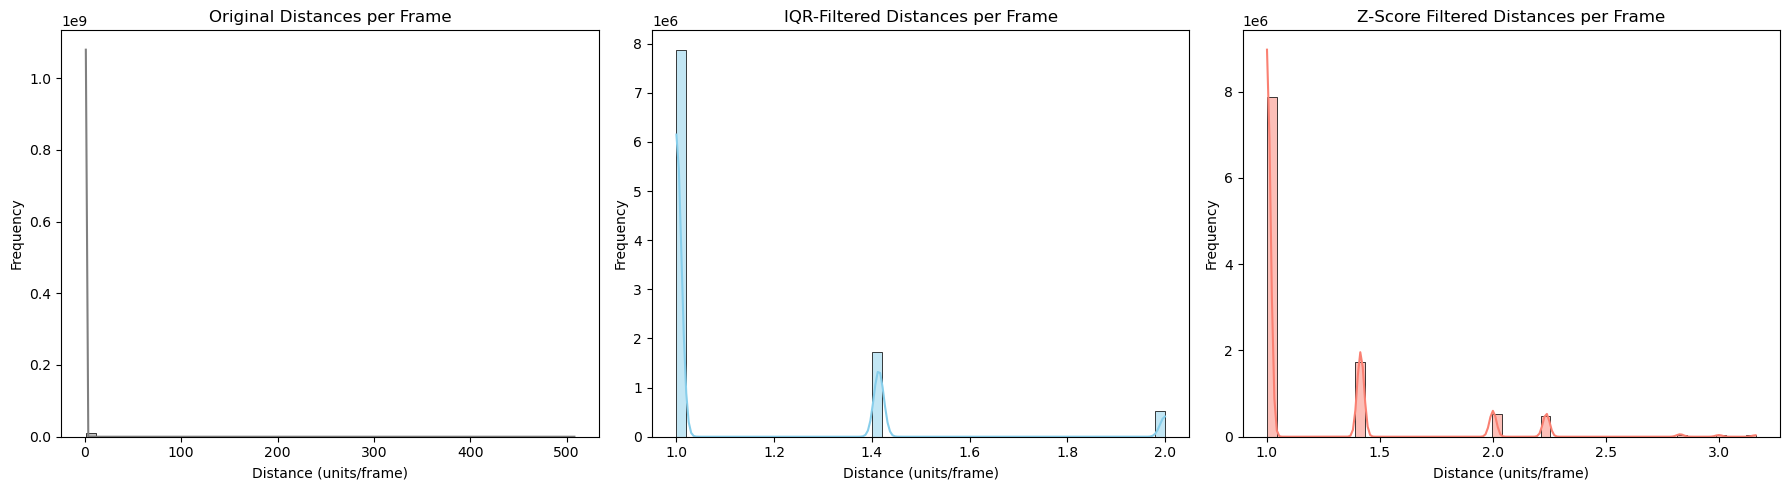

/opt/homebrew/Caskroom/miniforge/base/envs/wannts/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniforge/base/envs/wannts/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/wannts/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniforge/base/envs/wannts/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWar

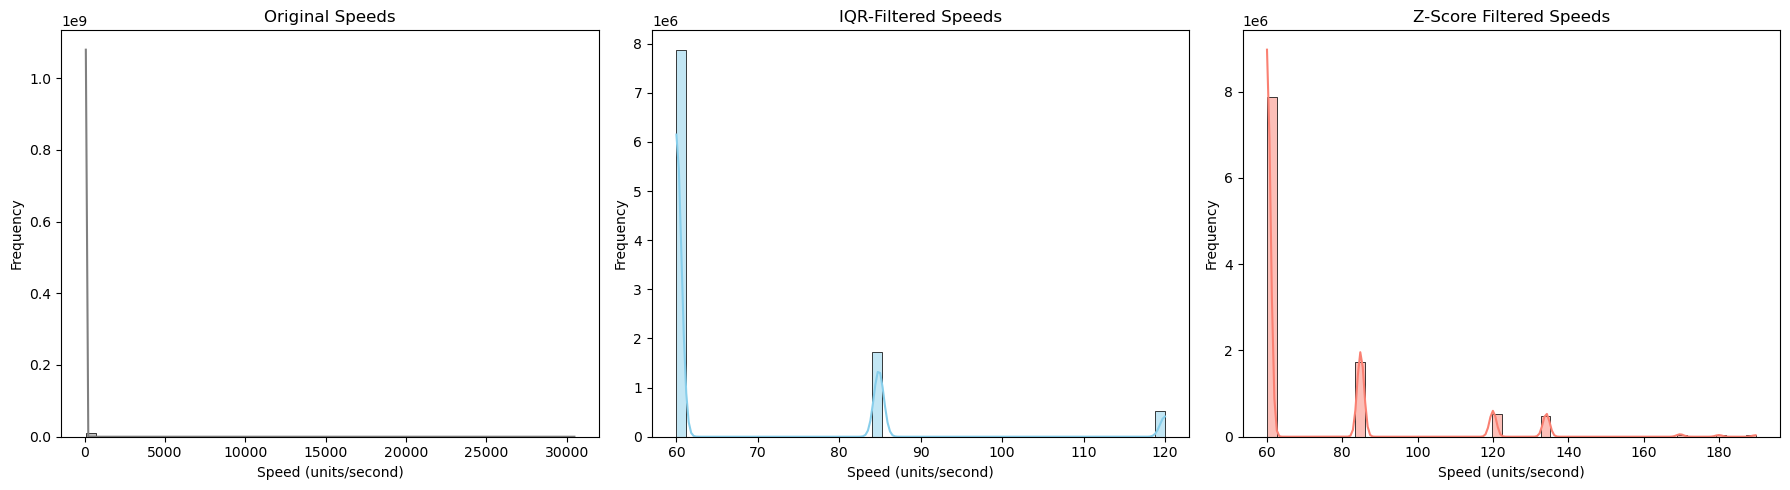

/opt/homebrew/Caskroom/miniforge/base/envs/wannts/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniforge/base/envs/wannts/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/wannts/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniforge/base/envs/wannts/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWar

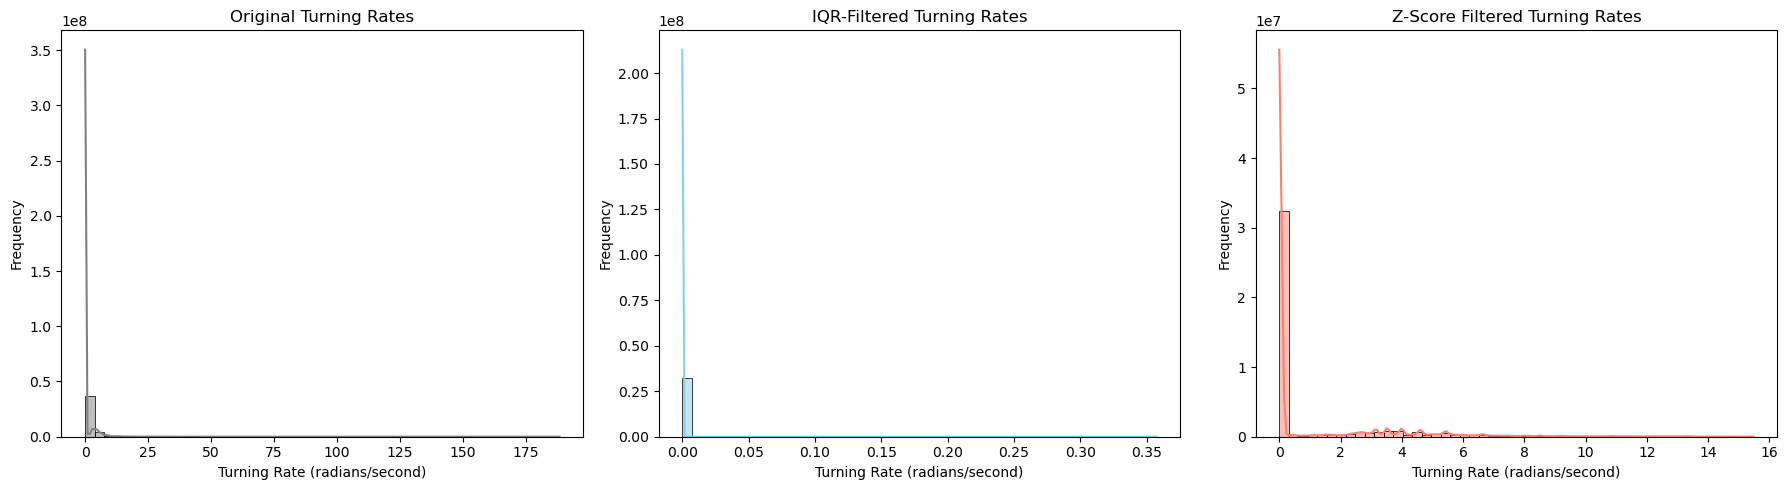

=== IQR-Filtered Metrics ===
Maximum distance traveled by an ant in a single frame: 2.00 units/frame
Average distance traveled by an ant per frame (excluding non-movement): 1.12 units/frame
Maximum speed of an ant: 120.00 units/second
Average speed of an ant (excluding non-movement): 67.36 units/second
Maximum turning rate of an ant: 0.3575 radians/second (20.48 degrees/second)
Average turning rate of an ant: 0.0008 radians/second (0.04 degrees/second)

=== Z-Score Filtered Metrics ===
Maximum distance traveled by an ant in a single frame: 3.16 units/frame
Average distance traveled by an ant per frame (excluding non-movement): 1.19 units/frame
Maximum speed of an ant: 189.74 units/second
Average speed of an ant (excluding non-movement): 71.47 units/second
Maximum turning rate of an ant: 15.4874 radians/second (887.37 degrees/second)
Average turning rate of an ant: 1.1266 radians/second (64.55 degrees/second)


In [10]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Define the framerate
FRAME_RATE = 60  # frames per second

# Load the dataframe from the pickle file
df = data

# Initialize lists to store all distances, speeds, and turning rates
all_distances = []          # Distance per frame
all_speeds = []             # Speed in units per second
all_turning_rates_sec = []  # Turning rates in radians per second

# Iterate through each ant and compute metrics
for ant in df.columns.levels[0]:  # Iterate over each ant (0 to 56)
    ant_data = df[ant].dropna()    # Remove rows where this ant has no data

    if len(ant_data) < 2:
        continue  # Need at least two points to compute differences

    # Calculate differences in positions
    delta_x = ant_data['x'].diff()
    delta_y = ant_data['y'].diff()
    distance = np.sqrt(delta_x**2 + delta_y**2)

    # Append non-zero distances
    non_zero_distances = distance[distance > 0].tolist()
    all_distances.extend(non_zero_distances)

    # Calculate speeds (units per second)
    speed = distance * FRAME_RATE  # units/frame * frames/second = units/second
    non_zero_speeds = speed[speed > 0].tolist()
    all_speeds.extend(non_zero_speeds)

    # Calculate differences in smoothed_theta
    delta_theta = ant_data['smoothed_theta'].diff().abs()

    # Handle angle wrapping
    delta_theta = delta_theta.apply(lambda x: min(x, 2*np.pi - x))

    # Calculate turning rates in radians per second
    turning_rates_sec = delta_theta.dropna() * FRAME_RATE
    all_turning_rates_sec.extend(turning_rates_sec.tolist())

# Define outlier removal functions
def remove_outliers_iqr(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    filtered_data = [x for x in data if lower_bound <= x <= upper_bound]
    return filtered_data

def remove_outliers_zscore(data, threshold=3):
    data_array = np.array(data)
    z_scores = np.abs(stats.zscore(data_array))
    filtered_data = data_array[z_scores < threshold].tolist()
    return filtered_data

# Apply IQR outlier removal
distances_iqr = remove_outliers_iqr(all_distances)
speeds_iqr = remove_outliers_iqr(all_speeds)
turning_rates_sec_iqr = remove_outliers_iqr(all_turning_rates_sec)

# Apply Z-score outlier removal
distances_z = remove_outliers_zscore(all_distances, threshold=3)
speeds_z = remove_outliers_zscore(all_speeds, threshold=3)
turning_rates_sec_z = remove_outliers_zscore(all_turning_rates_sec, threshold=3)

# Function to plot distributions
def plot_distributions(original, iqr_filtered, z_filtered, title, xlabel):
    plt.figure(figsize=(18, 5))

    plt.subplot(1, 3, 1)
    sns.histplot(original, bins=50, kde=True, color='gray')
    plt.title(f'Original {title}')
    plt.xlabel(xlabel)
    plt.ylabel('Frequency')

    plt.subplot(1, 3, 2)
    sns.histplot(iqr_filtered, bins=50, kde=True, color='skyblue')
    plt.title(f'IQR-Filtered {title}')
    plt.xlabel(xlabel)
    plt.ylabel('Frequency')

    plt.subplot(1, 3, 3)
    sns.histplot(z_filtered, bins=50, kde=True, color='salmon')
    plt.title(f'Z-Score Filtered {title}')
    plt.xlabel(xlabel)
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Plot distributions for visual comparison
plot_distributions(all_distances, distances_iqr, distances_z, 'Distances per Frame', 'Distance (units/frame)')
plot_distributions(all_speeds, speeds_iqr, speeds_z, 'Speeds', 'Speed (units/second)')
plot_distributions(all_turning_rates_sec, turning_rates_sec_iqr, turning_rates_sec_z, 'Turning Rates', 'Turning Rate (radians/second)')

# Compute maximum and average metrics after IQR Outlier Removal
max_distance_iqr = max(distances_iqr) if distances_iqr else 0
avg_distance_iqr = np.mean(distances_iqr) if distances_iqr else 0

max_speed_iqr = max(speeds_iqr) if speeds_iqr else 0
avg_speed_iqr = np.mean(speeds_iqr) if speeds_iqr else 0

max_turning_rate_sec_iqr = max(turning_rates_sec_iqr) if turning_rates_sec_iqr else 0
avg_turning_rate_sec_iqr = np.mean(turning_rates_sec_iqr) if turning_rates_sec_iqr else 0

# Convert turning rates to degrees per second
max_turning_rate_deg_sec_iqr = np.degrees(max_turning_rate_sec_iqr)
avg_turning_rate_deg_sec_iqr = np.degrees(avg_turning_rate_sec_iqr)

# Compute maximum and average metrics after Z-Score Outlier Removal
max_distance_z = max(distances_z) if distances_z else 0
avg_distance_z = np.mean(distances_z) if distances_z else 0

max_speed_z = max(speeds_z) if speeds_z else 0
avg_speed_z = np.mean(speeds_z) if speeds_z else 0

max_turning_rate_sec_z = max(turning_rates_sec_z) if turning_rates_sec_z else 0
avg_turning_rate_sec_z = np.mean(turning_rates_sec_z) if turning_rates_sec_z else 0

# Convert turning rates to degrees per second
max_turning_rate_deg_sec_z = np.degrees(max_turning_rate_sec_z)
avg_turning_rate_deg_sec_z = np.degrees(avg_turning_rate_sec_z)

# Display the results
print("=== IQR-Filtered Metrics ===")
print(f"Maximum distance traveled by an ant in a single frame: {max_distance_iqr:.2f} units/frame")
print(f"Average distance traveled by an ant per frame (excluding non-movement): {avg_distance_iqr:.2f} units/frame")
print(f"Maximum speed of an ant: {max_speed_iqr:.2f} units/second")
print(f"Average speed of an ant (excluding non-movement): {avg_speed_iqr:.2f} units/second")
print(f"Maximum turning rate of an ant: {max_turning_rate_sec_iqr:.4f} radians/second ({max_turning_rate_deg_sec_iqr:.2f} degrees/second)")
print(f"Average turning rate of an ant: {avg_turning_rate_sec_iqr:.4f} radians/second ({avg_turning_rate_deg_sec_iqr:.2f} degrees/second)")

print("\n=== Z-Score Filtered Metrics ===")
print(f"Maximum distance traveled by an ant in a single frame: {max_distance_z:.2f} units/frame")
print(f"Average distance traveled by an ant per frame (excluding non-movement): {avg_distance_z:.2f} units/frame")
print(f"Maximum speed of an ant: {max_speed_z:.2f} units/second")
print(f"Average speed of an ant (excluding non-movement): {avg_speed_z:.2f} units/second")
print(f"Maximum turning rate of an ant: {max_turning_rate_sec_z:.4f} radians/second ({max_turning_rate_deg_sec_z:.2f} degrees/second)")
print(f"Average turning rate of an ant: {avg_turning_rate_sec_z:.4f} radians/second ({avg_turning_rate_deg_sec_z:.2f} degrees/second)")

